In [1]:
import torch
from torchvision import datasets, transforms, models
import torchvision.models as models

import numpy as np
import json, time
from torch.nn.utils import parameters_to_vector as p2v

In [2]:
data_dir = "dataset"
IMAGE_SIZE = 224
BATCH_SIZE = 8

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

# plot the image
def show_image_prev(image_numpy_arr):
    fig, ax = plt.subplots()

    image = image_numpy_arr.transpose(1, 2, 0)
    print(image.shape)
    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<class 'torch.Tensor'>
torch.Size([8, 3, 224, 224])
torch.Size([8])
(224, 224, 3)


<Axes: >

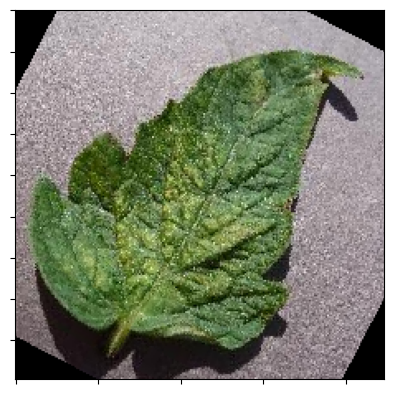

In [4]:
train_transforms = transforms.Compose([transforms.RandomRotation(30), #data augumnetation
                                       #transforms.RandomResizedCrop(IMAGE_SIZE),#resize
                                       transforms.CenterCrop(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(), #data augumnetation
                                       transforms.ToTensor(),
                                       #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

val_transforms = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.CenterCrop(IMAGE_SIZE), #resize
                                     transforms.ToTensor(),
                                     #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
val_data = datasets.ImageFolder(data_dir + '/val', transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE)

dataiter = iter(train_loader)
images, classes = next(dataiter)
print(type(images))
print(images.shape)
print(classes.shape)

show_image_prev(np.array(images[0]))

In [5]:
train_data.class_to_idx

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___Leaf_Mold': 3,
 'Tomato___Septoria_leaf_spot': 4,
 'Tomato___Spider_mites Two-spotted_spider_mite': 5,
 'Tomato___Target_Spot': 6,
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 7,
 'Tomato___Tomato_mosaic_virus': 8,
 'Tomato___healthy': 9}

In [6]:
len(train_data.class_to_idx)

10

In [6]:
import torch.optim as optim
import torch.nn as nn
import numpy as np

model = models.alexnet()

In [7]:
(model.classifier._modules)['6'] = nn.Linear(4096, len(train_data.class_to_idx))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [8]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
model.load_state_dict(torch.load("alexnet.torch", weights_only=True))

<All keys matched successfully>

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
device

device(type='cuda')

In [12]:
valid_accuracy_track = []

In [13]:
epochs = 25 # run more iterations

start_time = time.time()
for epoch in range(epochs):
    running_loss = 0
    model.train()
    for images, classes in train_loader:
        #continue
        # To device - to transfrom the image and classes to CPU|GPU
        images, classes = images.to(device), classes.to(device)
        
        # clears old gradients from the last step
        optimizer.zero_grad()

        # train the images
        outputs = model(images)

        #calculate the loss given the outputs and the classes
        loss = criterion(outputs, classes)

        # compute the loss of every parameter
        loss.backward()

        # apply the optimizer and its parameters
        optimizer.step()

        #update the loss
        running_loss += loss.item()

    else: # doesnt run if i break out of loop
        validation_loss = 0
        accuracy = 0
        
        # to make the model run faster we are using the gradients on the train
        with torch.no_grad():
            # specify that this is validation and not training
            model.eval()
            for images, classes in val_loader:          
                # Use GPU
                images, classes = images.to(device), classes.to(device)
                
                # validate the images
                outputs = model(images)

                # compute validation loss
                loss = criterion(outputs, classes)

                #update loss
                validation_loss += loss.item()

                # get the exponential of the outputs
                ps = torch.exp(outputs)

                #Returns the k largest elements of the given input tensor along a given dimension.
                top_p, top_class = ps.topk(1, dim=1)

                # reshape the tensor
                equals = top_class == classes.view(*top_class.shape)
                #print(type(equals), equals)

                # calculate the accuracy.
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        # change the mode to train for the next epochs

        print("Epoch: {}/{}.. ".format(epoch+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
              "Valid Loss: {:.3f}.. ".format(validation_loss/len(val_loader)),
              "Valid Accuracy: {:.3f}".format(accuracy/len(val_loader))
             )
        valid_accuracy_track.append((accuracy/len(val_loader)).item())


end_time = time.time()

elapsed = end_time - start_time

Epoch: 1/25..  Training Loss: 2.281..  Valid Loss: 2.313..  Valid Accuracy: 0.107
Epoch: 2/25..  Training Loss: 2.303..  Valid Loss: 2.302..  Valid Accuracy: 0.105
Epoch: 3/25..  Training Loss: 2.245..  Valid Loss: 2.241..  Valid Accuracy: 0.149
Epoch: 4/25..  Training Loss: 2.037..  Valid Loss: 1.791..  Valid Accuracy: 0.347
Epoch: 5/25..  Training Loss: 1.692..  Valid Loss: 2.120..  Valid Accuracy: 0.299
Epoch: 6/25..  Training Loss: 1.277..  Valid Loss: 2.221..  Valid Accuracy: 0.405
Epoch: 7/25..  Training Loss: 0.878..  Valid Loss: 1.900..  Valid Accuracy: 0.438
Epoch: 8/25..  Training Loss: 0.672..  Valid Loss: 0.623..  Valid Accuracy: 0.770
Epoch: 9/25..  Training Loss: 0.527..  Valid Loss: 0.351..  Valid Accuracy: 0.879
Epoch: 10/25..  Training Loss: 0.438..  Valid Loss: 0.298..  Valid Accuracy: 0.894
Epoch: 11/25..  Training Loss: 0.364..  Valid Loss: 0.513..  Valid Accuracy: 0.821
Epoch: 12/25..  Training Loss: 0.321..  Valid Loss: 0.262..  Valid Accuracy: 0.906
Epoch: 13/25.

In [14]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["valid_accuracy"]["alexnet"] = valid_accuracy_track
stats["time_taken"]["alexnet"] = elapsed
stats["params"]["alexnet"] = p2v(model.parameters()).numel()

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

In [27]:
torch.save(model.state_dict(), "alexnet.torch")

In [11]:
model.class_to_idx = train_data.class_to_idx
model.class_to_idx.items()

dict_items([('Tomato___Bacterial_spot', 0), ('Tomato___Early_blight', 1), ('Tomato___Late_blight', 2), ('Tomato___Leaf_Mold', 3), ('Tomato___Septoria_leaf_spot', 4), ('Tomato___Spider_mites Two-spotted_spider_mite', 5), ('Tomato___Target_Spot', 6), ('Tomato___Tomato_Yellow_Leaf_Curl_Virus', 7), ('Tomato___Tomato_mosaic_virus', 8), ('Tomato___healthy', 9)])

In [12]:
def plot_solution(image_path, ps, classes):
    plt.figure(figsize = (6,10))
    plt.subplot(2,1,2)
    sns.barplot(x=ps, y=classes, color=sns.color_palette()[2]);
    plt.show()

# plot the image
def show_image(image_numpy_arr):
    fig, ax = plt.subplots()

    # convert the shape from (3, 256, 256) to (256, 256, 3)
    image = image_numpy_arr.transpose(1, 2, 0)

    ax.imshow(image)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def process_image(image_path, show):
    test_transform = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.RandomRotation(30), transforms.CenterCrop(IMAGE_SIZE), transforms.ToTensor()])
    im = Image.open(image_path)
    im = test_transform(im)
    if show: show_image(np.array(im))
    return im

In [13]:
def predict(image, model, show=True):
    with torch.no_grad():
        model.eval()
        image = process_image(image, show)
        image_inp = image.unsqueeze(0)
        
        image_inp = image_inp.to(device)
        
        outputs = model(image_inp)
    
    #print("debug: ", )
    #ps = torch.exp(outputs)
    ps = torch.nn.functional.softmax(outputs, dim=1)

    top_p, top_cls = ps.topk(5, dim=1)
    top_cls = top_cls.cpu().numpy().tolist()[0]

    idx_to_class = {v: k for k, v in model.class_to_idx.items()}

    top_cls = [idx_to_class[top_class] for top_class in top_cls]
    return top_p, top_cls

In [14]:
def predict_file(image, model):
    ps, classes = predict(image, model)
    ps = ps.cpu().detach().numpy().tolist()[0]
    print(ps)
    print(classes)
    plot_solution(image, ps, classes)

[0.9999973773956299, 2.09518771043804e-06, 4.952823928761063e-07, 2.1520714099665383e-08, 1.4869953046670048e-09]
['Tomato___healthy', 'Tomato___Target_Spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Late_blight', 'Tomato___Leaf_Mold']


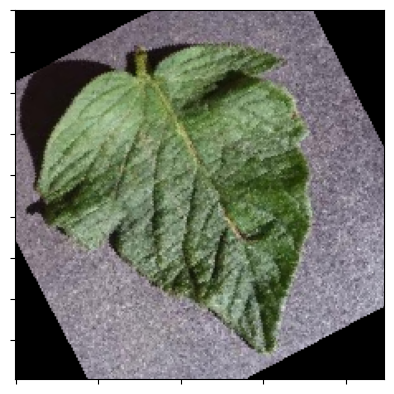

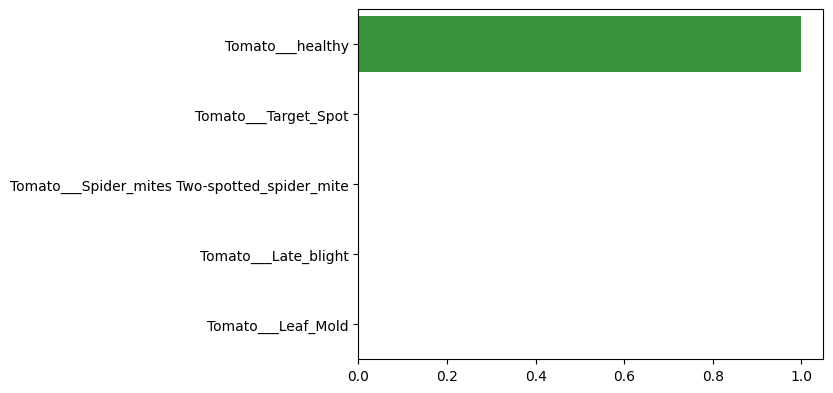

In [15]:
folder = 'Tomato___healthy'
file = '3eaf72d6-be20-4929-b6dc-58f6c9edf2bd___RS_HL 0031_flipTB.JPG'
image = f"dataset/val/{folder}/{file}"
predict_file(image, model)

[0.9975333213806152, 0.0012159832986071706, 0.0009498638100922108, 0.00010773004760267213, 0.00010358143481425941]
['Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___healthy', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Late_blight']


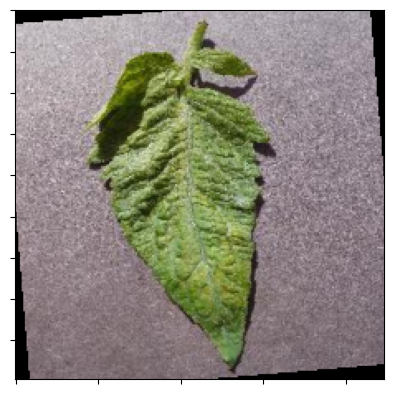

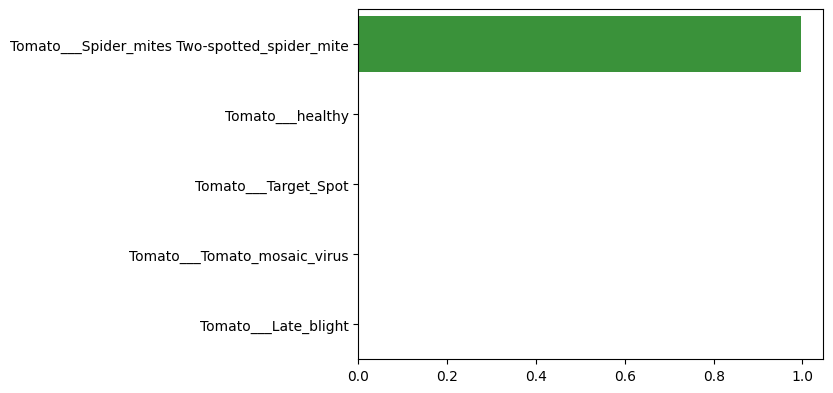

In [16]:
folder = 'Tomato___Spider_mites Two-spotted_spider_mite'
file = '3cf4bee8-cd23-461c-b1c4-1d857b37ad76___Com.G_SpM_FL 1223_180deg.JPG'
image = f"dataset/val/{folder}/{file}"
predict_file(image, model)

[0.9999997615814209, 1.6232422694884008e-07, 7.369545329538596e-08, 2.2652900000252885e-08, 1.102488500492882e-08]
['Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Early_blight', 'Tomato___Leaf_Mold', 'Tomato___Target_Spot']


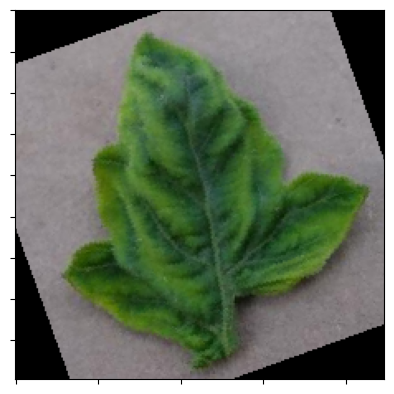

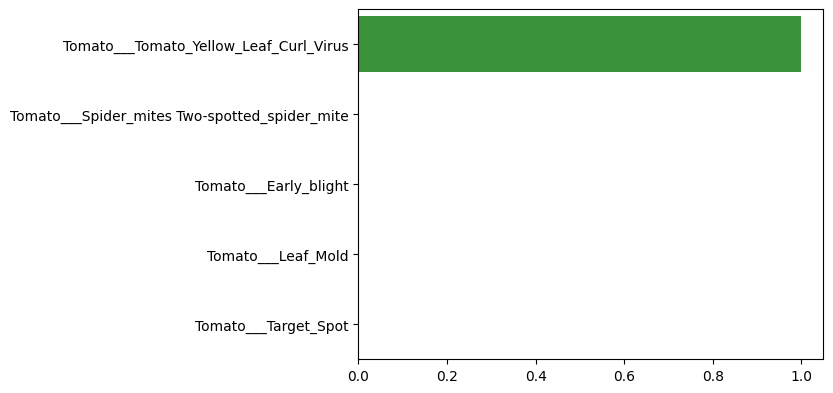

In [17]:
folder = 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
file = '599329fe-867f-402a-8d37-a0c351fc2d03___YLCV_GCREC 2822.JPG'
image = f"dataset/val/{folder}/{file}"
predict_file(image, model)

[0.9957941770553589, 0.0031874587293714285, 0.0009452864178456366, 6.153765571070835e-05, 9.747783224156592e-06]
['Tomato___Early_blight', 'Tomato___Bacterial_spot', 'Tomato___Septoria_leaf_spot', 'Tomato___Late_blight', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


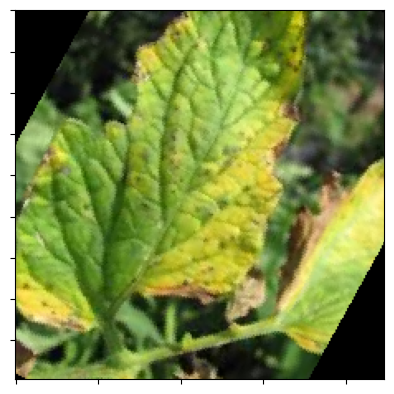

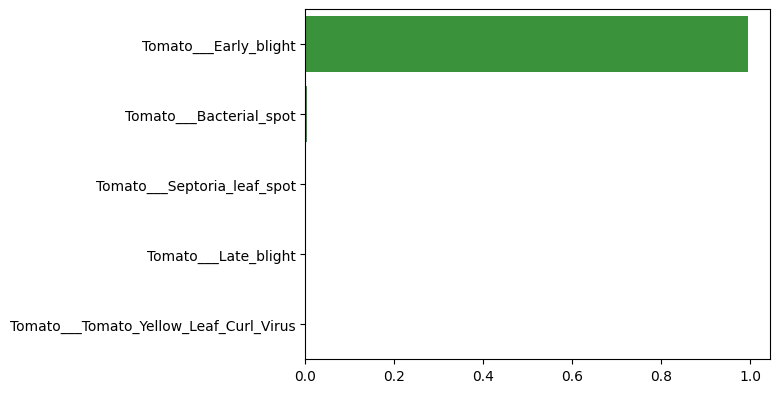

In [18]:
# test

file = 'image_bacterial_spot.jpg'
image = f"dataset/test/{file}"
predict_file(image, model)

[0.99998939037323, 5.367347057472216e-06, 3.401044523343444e-06, 1.3436526842269814e-06, 4.930234922539967e-07]
['Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Target_Spot', 'Tomato___Leaf_Mold', 'Tomato___Spider_mites Two-spotted_spider_mite']


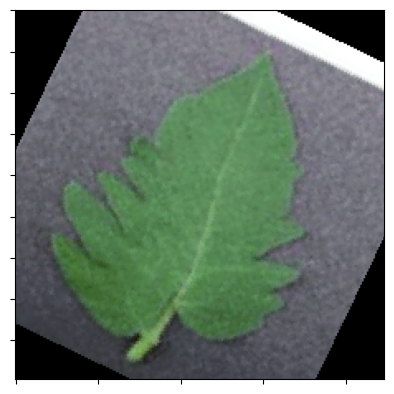

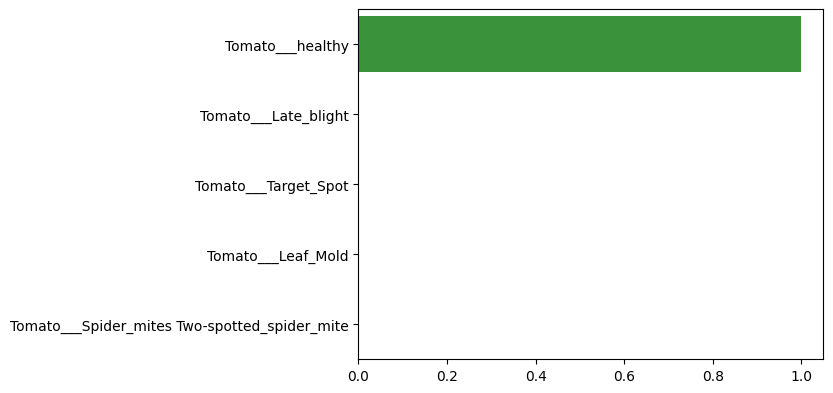

In [19]:
# test

file = 'image_healthy.jpg'
image = f"{data_dir}/test/{file}"
predict_file(image, model)

[0.9990170001983643, 0.0008640371961519122, 0.00010779184231068939, 6.4612777350703254e-06, 3.5387733987590764e-06]
['Tomato___Late_blight', 'Tomato___Early_blight', 'Tomato___Septoria_leaf_spot', 'Tomato___Leaf_Mold', 'Tomato___Target_Spot']


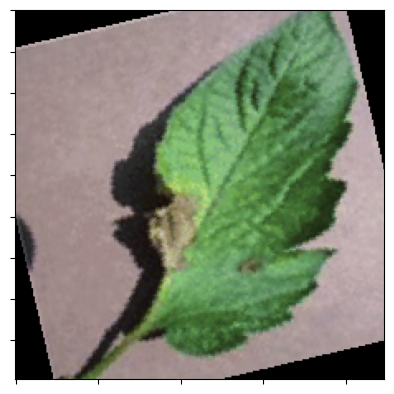

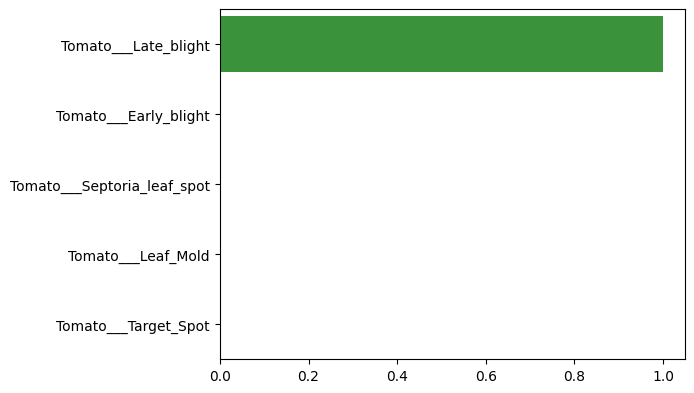

In [20]:
# test

#folder = 'Tomato___Tomato_Yellow_Leaf_Curl_Virus'
file = 'image_late_blight.jpg'
image = f"dataset/test/{file}"
predict_file(image, model)

In [21]:
import os

accuracy = total = 0

true_list = []
pred = []

for (root, dirs, files) in os.walk(data_dir + "\\val"):
    if len(files) == 0:
        continue

    folder = root.split("\\")[-1]

    fol_acc = fol_tot = 0
    
    for file in files:
        image = f"{data_dir}/val/{folder}/{file}"
        ps, classes = predict(image, model, False)
        if classes[0] == folder:
            accuracy += 1
            fol_acc += 1

        true_list.append(folder)
        pred.append(classes[0])
        total += 1
        fol_tot += 1

    print(f"{folder}: {fol_acc}/{fol_tot} OR {fol_acc/fol_tot :.2f}")

print("\n")
print(f"FINAL: {accuracy}/{total} OR {accuracy/total :.2f}")

Tomato___Bacterial_spot: 396/425 OR 0.93
Tomato___Early_blight: 437/480 OR 0.91
Tomato___healthy: 481/481 OR 1.00
Tomato___Late_blight: 442/463 OR 0.95
Tomato___Leaf_Mold: 465/470 OR 0.99
Tomato___Septoria_leaf_spot: 395/436 OR 0.91
Tomato___Spider_mites Two-spotted_spider_mite: 430/435 OR 0.99
Tomato___Target_Spot: 328/457 OR 0.72
Tomato___Tomato_mosaic_virus: 446/448 OR 1.00
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 486/490 OR 0.99


FINAL: 4306/4585 OR 0.94


In [22]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["final_accuracy"]["alexnet"] = accuracy/total

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

[Text(0.5, 23.38159722222222, 'Pred'), Text(77.78159722222226, 0.5, 'Truth')]

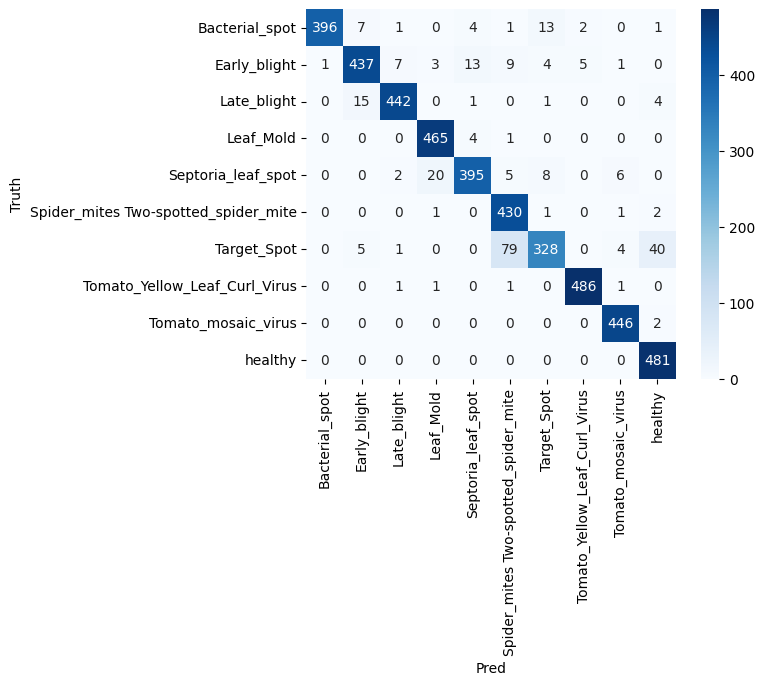

In [23]:
from sklearn.metrics import confusion_matrix

classes_list = list(sorted(model.class_to_idx.keys()))

matrix_confusion = confusion_matrix(true_list, pred, labels=classes_list)

classes_list = [i[9:] for i in classes_list]
ax = sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', xticklabels=classes_list, yticklabels=classes_list)
#sns.heatmap(glue, annot=True)
ax.set(xlabel="Pred", ylabel="Truth")

In [24]:
import torchmetrics
pred_tensor, truth_tensor = torch.Tensor([model.class_to_idx[i] for i in pred]), torch.Tensor([model.class_to_idx[i] for i in true_list])

acc = torchmetrics.functional.accuracy(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
precision = torchmetrics.functional.precision(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
recall = torchmetrics.functional.recall(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))
f1 = torchmetrics.functional.f1_score(pred_tensor, truth_tensor, average="macro", task="multiclass", num_classes=len(classes_list))

(acc, precision, recall, f1)

(tensor(0.9386), tensor(0.9416), tensor(0.9386), tensor(0.9375))

In [25]:
with open("stats.json", "r") as file:
    stats = json.loads(file.read())

stats["confusion_matrix"]["alexnet"] = np.array(matrix_confusion).tolist()
stats["metrics"]["accuracy"]["alexnet"] = float(acc)
stats["metrics"]["precision"]["alexnet"] = float(precision)
stats["metrics"]["recall"]["alexnet"] = float(recall)
stats["metrics"]["f1_score"]["alexnet"] = float(f1)

with open("stats.json", "w") as file:
    file.write(json.dumps(stats))

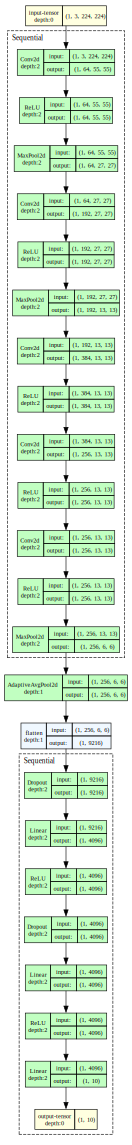

In [12]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(1, 3, 224, 224), device=device, expand_nested=True, save_graph=False)
model_graph.visual_graph.node_attr["fontname"] = "Times-Roman"
model_graph.visual_graph